# Test of GraphSAGE
- the version of the node feature noise
- use DGL
- predict `graphs`
- valid, test data are in the training dataset

In [1]:
import os
import dgl
import json
import torch
import torch as th
import dgl.nn as dglnn
# from tqdm import tqdm
from tqdm.notebook import tqdm  # 使用 notebook 版本的 tqdm
import torch.nn as nn
from dgl.nn import GraphConv, GATConv, SAGEConv
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup

- check the GPU and assign the GPU by the best memory usage

In [2]:
import subprocess
import torch

def get_free_gpu():
    try:
        # Run nvidia-smi command to get GPU details
        _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
        command = "nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader"
        memory_free_info = _output_to_list(subprocess.check_output(command.split())) 
        memory_free_values = [int(x) for i, x in enumerate(memory_free_info)]
        
        # Get the GPU with the maximum free memory
        best_gpu_id = memory_free_values.index(max(memory_free_values))
        return best_gpu_id
    except:
        # If any exception occurs, default to GPU 0 (this handles cases where nvidia-smi isn't installed)
        return 0

if torch.cuda.is_available():
    # Get the best GPU ID based on free memory and set it
    best_gpu_id = get_free_gpu()
    device = torch.device(f"cuda:{best_gpu_id}")
else:
    device = torch.device("cpu")
    print("there's no available GPU")

# device = torch.device(f"cuda:{1}")
print(device)


cuda:2


## Fix the seed

In [3]:
import numpy as np
import torch
import random

#fix seed
def same_seeds(seed = 8787):
    torch.manual_seed(seed)
    # random.seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Data Loader

In [16]:
class GraphDataset(Dataset):
    def __init__(self, data_list, device):
        self.data_list = data_list
        self.device = device

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data = self.data_list[idx]
        return data

# def collate(samples):
#     data_list = samples
#     batched_graphs = []
#     for data in data_list:
#         g = dgl.graph((th.tensor(data["edge_index"][0]), th.tensor(data["edge_index"][1])), num_nodes=data["num_nodes"])

#         g.ndata['feat'] = th.tensor(data["node_feat"])
#         g.edata['feat'] = th.tensor(data["edge_attr"])
#         g.edata['label'] = th.tensor(data["labels"])  # Add edge labels to graph

#         batched_graphs.append(g)
    
#     return dgl.batch(batched_graphs)

def collate(samples):
    data_list = samples
    batched_graphs = []
    for data in data_list:
        g = dgl.graph((th.tensor(data["edge_index"][0]), th.tensor(data["edge_index"][1])), num_nodes=data["num_nodes"])

        node_feat = th.tensor(data["node_feat"])
        
        noise = th.normal(mean=0, std=0.01, size=node_feat.shape, device=node_feat.device)
        node_feat += noise

        g.ndata['feat'] = node_feat
        g.edata['feat'] = th.tensor(data["edge_attr"])
        g.edata['label'] = th.tensor(data["labels"])  # Add edge labels to graph

        batched_graphs.append(g)
    
    return dgl.batch(batched_graphs)


In [17]:
datasets = ['train', 'valid', 'test']
# datasets = ['valid']
dataset_data = {}

for dataset_name in tqdm(datasets):
    file_path = f"../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/{dataset_name}.jsonl"
    
    print(file_path)
    with open(file_path) as f:
        data_list = [json.loads(line) for line in tqdm(f, position=0, leave=True)]
    
    dataset_data[dataset_name] = GraphDataset(data_list, device)

print("Datasets loaded!")

  0%|          | 0/3 [00:00<?, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/train.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/valid.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/test.jsonl


0it [00:00, ?it/s]

Datasets loaded!


- choose batch size

In [18]:
def create_dataloaders(batch_size, shuffle=True):
    dataloaders = {}
    for dataset_name, dataset in dataset_data.items():
        # do not shuffle the testing dataset
        if dataset_name == "test":
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)    
        else:
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    return dataloaders

dataloaders = create_dataloaders(16)

- Turn the print message to a log file

In [19]:
import datetime

now = datetime.datetime.now()

formatted_time = now.strftime("%m%d_%H:%M")

log_file_path = f"../log_message/{formatted_time}_GraphSAGE_transR_50.log"

def add_log_msg(msg, log_file_path=log_file_path):
    with open(log_file_path, 'a') as f:
        f.write(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}\n')
    print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}')

print(log_file_path)

../log_message/1011_12:51_GraphSAGE_transR_50.log


### Model

In [20]:
class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GraphSAGE, self).__init__()
        self.layer1 = dglnn.SAGEConv(in_dim, hidden_dim, 'pool')
        self.layer2 = dglnn.SAGEConv(hidden_dim, out_dim, 'pool')
        self.dropout = nn.Dropout(0.25)

    def forward(self, g, inputs):
        h = self.layer1(g, inputs)
        h = torch.relu(h)
#         h = self.dropout(h)
        h = self.layer2(g, h)
        return h

In [21]:
class MLPPredictor(nn.Module):
    def __init__(self, out_feats, out_classes):
        super().__init__()
        self.W = nn.Linear(out_feats*2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [22]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_classes):
        super().__init__()
        self.sage = GraphSAGE(in_features, hidden_features, out_features)
        self.pred = MLPPredictor(out_features, num_classes)
      
    def forward(self, g, node_feat, return_logits=False):
        h = self.sage(g, node_feat)
        logits = self.pred(g, h)
        
        return logits

- Model Forward  

In [23]:
def model_fn(batched_g, model, criterion, device, count=1, which_type='train'):
    """Forward a batch through the model."""
#     batched_g, labels = data
    batched_g = batched_g.to(device)
    
    labels = batched_g.edata['label'].to(device)
    
    logits = model(batched_g, batched_g.ndata['feat'].float())

    loss = criterion(logits, labels)

    output = torch.softmax(logits, dim=1)
    preds = output.argmax(1)
    
    # Compute accuracy
    accuracy = torch.mean((preds == labels).float())
    
    if which_type == 'validation' and count % 1000 == 0:
        add_log_msg(f"labels of Validation: {labels} {labels.shape}")
        add_log_msg(f"predicted of Validation: {preds} {preds.shape}")
        
    elif which_type == 'test'  and count % 1000 == 0:
        add_log_msg(f"labels of Test: {labels} {labels.shape}")
        add_log_msg(f"predicted of Test: {preds} {preds.shape}")
        
    if count % 5000 == 0: 
        add_log_msg(f"labels of {count}: {labels} {labels.shape}")
        add_log_msg(f"predicted of {count}: {preds} {preds.shape}")
        
    return loss, accuracy, preds

### Training

- Fix the seed and save the model.state_dict that contains the initial weight

In [24]:
seed = 8787
same_seeds(seed)

model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
torch.save(model.state_dict(), 'model3_initial(graphsage)/initial_weight.pth')

In [25]:
# model.layer1.fc_self.weight
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.0682,  0.0153, -0.1769,  ...,  0.0375,  0.2321, -0.2812],
        [-0.2271,  0.2290, -0.1997,  ..., -0.0095,  0.1509,  0.2686],
        [-0.2743,  0.0406, -0.1222,  ...,  0.1036, -0.1590, -0.2555],
        ...,
        [-0.0758,  0.0461,  0.1273,  ...,  0.1367,  0.0671, -0.2605],
        [-0.2425, -0.1362,  0.2474,  ..., -0.3221, -0.0595,  0.3141],
        [ 0.0234, -0.2783,  0.2146,  ..., -0.3020, -0.1751,  0.0528]],
       requires_grad=True)

- Check if model really load the model_dict

In [26]:
model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.0682,  0.0153, -0.1769,  ...,  0.0375,  0.2321, -0.2812],
        [-0.2271,  0.2290, -0.1997,  ..., -0.0095,  0.1509,  0.2686],
        [-0.2743,  0.0406, -0.1222,  ...,  0.1036, -0.1590, -0.2555],
        ...,
        [-0.0758,  0.0461,  0.1273,  ...,  0.1367,  0.0671, -0.2605],
        [-0.2425, -0.1362,  0.2474,  ..., -0.3221, -0.0595,  0.3141],
        [ 0.0234, -0.2783,  0.2146,  ..., -0.3020, -0.1751,  0.0528]],
       requires_grad=True)

In [28]:
import csv
import pandas as pd
from sklearn.metrics import classification_report
from torch.optim import AdamW, lr_scheduler

seed = 5269
same_seeds(seed)

# model = GraphSAGE(in_dim=50, hidden_dim=16, out_dim=167)
model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
# in_dim means the dimension of the node_feat(50 dim, since the 50-dim embedding)
# out_dim means the # of the categories -> 168 for out tasks
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
best_model_path = "../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-6.pt"

model = model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=18, num_training_steps=total_steps)

# T_max control the period of the lr changing -> set 1/10 first
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0, last_epoch=- 1, verbose=False)

criterion = nn.CrossEntropyLoss()
# criterion = torch.nn.BCEWithLogitsLoss()

total_steps = 50

# save the best model
best_val_loss = float('inf')
patience = 10  # Number of epochs with no improvement after which training will be stopped.
waiting = 0  # The number of epochs with no improvement so far.


# Training Part
for epoch in tqdm(range(total_steps)):
    # Train
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0
    
    for batched_g in tqdm(dataloaders['train'], desc="Training", position=0, leave=True):
        num_batches += 1
        loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='train')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

    scheduler.step()
    add_log_msg(f"total batches: {num_batches}")

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    add_log_msg(f'Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_accuracy:.4f}')

    
    # Validation Part
    model.eval()
    total_accuracy = 0.0
    total_loss = 0.0
    num_batches = 0


    with torch.no_grad():
        for batched_g in tqdm(dataloaders['valid'], desc="Validation", position=0, leave=True):
            loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='validation')
            total_accuracy += accuracy.item()
            total_loss += loss.item()
            num_batches += 1

    avg_accuracy = total_accuracy / num_batches
    current_loss = total_loss / num_batches
    
    add_log_msg(f'Validation Loss: {current_loss:.4f} | Validation Accuracy: {avg_accuracy:.4f}\n')
    
            
    if current_loss < best_val_loss:
        best_val_loss = current_loss
        waiting = 0
        
        if os.path.exists(best_model_path):
            os.remove(best_model_path)
            add_log_msg("Find a better model!!")

        torch.save(model.state_dict(), best_model_path)

#         print(best_model_path)

    else:
        waiting += 1
        if waiting >= patience:
            add_log_msg("============================== Early stopping ==================================")
            break

  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 12:52:27# labels of 5000: tensor([  8,   8,  94,  94, 113, 113, 126, 126, 126,  65, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 119, 138, 138,
        138, 138, 138, 138, 138, 138, 138, 138,  35,  35,  35,  35,  35,  35,
        148, 148, 148, 148, 148, 148, 148, 136, 136, 136, 136, 136, 136, 136,
         62,  62,  62,  62,  62,  62, 153, 153, 153,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  31, 155,  65

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 12:53:17# labels of Validation: tensor([ 65,  65,  65, 135, 135,  74,  78,  78,  78,  78,  78,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  60,  76,  83,  95,  95,  95, 131, 131, 131,
        131, 131,  80,  80,  80,  80,  80,  80,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,  29,  29,  29,  29,  29,
         29,  29,  29,  29,  29,  29,  29,  29,  29,  29,  29,  29,  29,  29,
         29,   8,   8,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
         28,  90,  90], device='cuda:2') torch.Size([101])
10/11/2023, 12:53:17# predicted of Validation: tensor([ 65,  65,  65, 135, 135, 129,  67,  67,  67,  67,  67,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99, 131,  51,  67,  95,  95,  95, 131, 131, 131,
        131, 131,  80,  80,  80,  80,  80,  80,   3,   3,   3,   3,   

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 12:54:38# labels of 5000: tensor([140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140,  12,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65, 141, 141, 141, 141, 141, 141,
        141, 141, 141, 141,  40,  40,  40,  40,  40,  40,  20,  20, 143,  26,
         26,  26,  26,  26,  26,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 147,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65, 147, 147, 147, 147,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 12:55:23# labels of Validation: tensor([ 52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,   6,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 12:55:33# labels of Validation: tensor([150,  24, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 154, 154, 154,
        154, 154, 15

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 12:56:43# labels of 5000: tensor([ 52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  65,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,   5,   5,
          5,   6,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,   6,   6,   6,   6,   6,   6,   6,   6,
          6,   6,   6,   6

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 12:57:27# labels of Validation: tensor([146, 146, 146, 146, 146, 146, 151,  31, 159, 159, 159, 159, 159, 159,
        159, 159, 159, 159,  62,  62,  62,  62,  62,  62, 115, 115, 115, 115,
        115, 115, 115, 115, 115, 115, 148, 148, 148, 148, 148, 148, 148, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 16

10/11/2023, 12:57:38# labels of Validation: tensor([114, 114,  98, 107, 107, 107, 107, 107, 107, 107, 107,   8,   8,  75,
        146, 146, 146, 146, 146, 146,   4,  12, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 115, 115, 115, 115,
        115, 115, 115, 115, 115, 115,  20,  20,   6,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,   6,   6,   6,   6,   6,   6,   6,   6,
          6,   6,   6,   6,   6,   6,   6,   6,   6,   6, 129, 129, 129, 129,
        129, 129, 129,  35,  35,  35,  35,  35,  35,  72,  72,  83],
       device='cuda:2') torch.Size([138])
10/11/2023, 12:57:38# predicted of Validation: tensor([ 16,  94,  98, 107, 107, 107, 107, 107, 107, 107, 107,  61,  61,  62,
        146, 146, 

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 12:58:50# labels of 5000: tensor([117, 117, 117, 152,  14,  44, 129, 129, 129, 129, 129, 129, 129, 129,
        129, 129, 129, 129, 129, 129,  67,  67,  67,  67,  67,   1,   9, 155,
         65,  65, 155, 155, 155,   2,  80,  80,  80,  80,  80,  80,  40,  40,
         40,  40,  40,  40,   8,   8,  40,  40,  40,  40,  40,  40,  94,  94],
       device='cuda:2') torch.Size([56])
10/11/2023, 12:58:50# predicted of 5000: tensor([117, 117, 117,  89,  87,  73, 129, 129, 129, 129, 129, 129, 129, 129,
        129, 129, 129, 129, 129, 129,  78,  78,  78,  78,  78, 131,  67, 155,
         65,  65, 155, 155, 155, 131,  80,  80,  80,  80,  80,  80,  40,  40,
         40,  40,  40,  40, 131, 131,  40,  40,  40,  40,  40,  40,  94,  94],
       device='cuda:2') torch.Size([56])
10/11/2023, 12:59:42# total batches: 8250
10/11/2023, 12:59:42# Epoch 3 | Train Loss: 0.3123 | Train Accuracy: 0.9290


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 12:59:42# labels of Validation: tensor([ 66,  66,  66,  66,  66,  66,  66,  66,  66,  66,  89,  89, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 116,
        103, 103,  43,  43,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,
         21, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 155,  65,  65,
        155, 155, 15

10/11/2023, 12:59:53# Validation Loss: 0.3164 | Validation Accuracy: 0.9279

10/11/2023, 12:59:53# Find a better model!!


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:01:14# labels of 5000: tensor([ 30,  65,  46,  ..., 126, 126, 126], device='cuda:2') torch.Size([1321])
10/11/2023, 13:01:14# predicted of 5000: tensor([110,  65,  46,  ..., 126, 126, 126], device='cuda:2') torch.Size([1321])
10/11/2023, 13:02:08# total batches: 8250
10/11/2023, 13:02:08# Epoch 4 | Train Loss: 0.3082 | Train Accuracy: 0.9294


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:02:08# labels of Validation: tensor([153, 153, 153,  31,  78,  78,  78,  78,  78,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  47, 166, 166, 166, 166, 166, 166, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101,  80,  80,  80,  80,
         80,  80,  67,  67,  67,  67,  67,  30,  40,  40,  40,  40,  40,  40,
          4,  13,  13,  13,  13,  13,  23,  23,  23,  23,  23,  26,  26,  26,
         26,  26,  26,  87], device='cuda:2') torch.Size([88])
10/11/2023, 13:02:08# predicted of Validation: tensor([153, 153, 153,  91,  67,  67,  67,  67,  67,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  72, 166, 166, 166, 166, 166, 166, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101,  80,  80,  80,  80,
         80,  80,  67,  67,  67,  67,  67, 130,  40,  40,  40,  40

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:03:31# labels of 5000: tensor([ 12,  95,  95,  95,  11,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  65,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52, 104, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:04:18# labels of Validation: tensor([ 43,  43,  89,  89,  97,  64,  64,  61,  61,  61, 136, 136, 136, 136,
        136, 136, 136, 114, 114,   9,   4,  39,  39,  39, 159, 159, 159, 159,
        159, 159, 159, 159, 159, 159,  65,  65,  65,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70, 158,  26,  26,  26,  26,  26,  26,  90,  90,  58,
         58,  58,  58,  58,  58,  58], device='cuda:2') torch.Size([76])
10/11/2023, 13:04:18# predicted of Validation: tensor([ 43,  43,  89,  89, 131, 131, 131,  61,  61,  61, 136, 136, 136, 136,
        136, 136, 136, 131, 131, 131, 149,  39,  39,  39, 159, 159, 159, 159,
        159, 159, 159, 159, 159, 159,  65,  65,  65,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70, 131,  26,  26,  26,  26,  26,  26, 131, 131,  58,
         58,  58,  58,  58,  58,  58], device='cuda:2') 

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:05:43# labels of 5000: tensor([ 81, 157,  40,  40,  40,  40,  40,  40,  47,  19,  19,  19,  19,  19,
         92,  23,  23,  23,  23,  23, 124,  91,  91,  91,  63,  63,  63,  63,
         63,  63,  63,  63,  98,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  65,
        123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123,  77,  77,  77,  77,  77,  77,  77,  77,  85,  85,  85,  85,  85,
         85,  85,  85,  85,  85,  85], device='cuda:2') torch.Size([118])
10/11/2023, 13:05:43# predicted of 5000: tensor([131, 108,  40,  40,  40,  40,  40,  40,  72,  19,  19,  19,  19,  19,
        131,  23,  23,  23,  23,  23, 131, 131, 131, 131,  63,  63,  63,  63,
         63,  63,  63,  63,  98,  25,  25,  25,  25,  25,  25,  25,

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:06:31# labels of Validation: tensor([ 25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  81,  14, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

10/11/2023, 13:06:42# Validation Loss: 0.3037 | Validation Accuracy: 0.9302

10/11/2023, 13:06:43# Find a better model!!


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:07:51# labels of 5000: tensor([ 51,  51,  51,  ..., 132, 132, 132], device='cuda:2') torch.Size([1325])
10/11/2023, 13:07:51# predicted of 5000: tensor([ 51,  51,  51,  ..., 132, 132, 132], device='cuda:2') torch.Size([1325])
10/11/2023, 13:08:37# total batches: 8250
10/11/2023, 13:08:37# Epoch 7 | Train Loss: 0.3056 | Train Accuracy: 0.9300


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:08:37# labels of Validation: tensor([ 77,  77,  77,  77,  77,  77,  77,  77,  42, 129, 129, 129, 129, 129,
        129, 129,  11, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 13:08:48# labels of Validation: tensor([121, 166, 166, 166, 166, 166, 166, 159, 159, 159, 159, 159, 159, 159,
        159, 159, 159,  61,  61,  61,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65, 135, 135, 157,  37,  37,  37,  37,  37,  43,  43,  47, 108,
        108, 108, 108,  50,  50,  50, 117, 117, 117, 143,  96,  96,  96,  96,
         96,  96,  75,  56,  56,  56,  56,  56,  56], device='cuda:2') torch.Size([65])
10/11/2023, 13:08:48# predicted of Validation: tensor([108, 166, 166, 166, 166, 166, 166, 159, 159, 159, 159, 159, 159, 159,
        159, 159, 159,  61,  61,  61,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65, 135, 135, 108,  37,  37,  37,  37,  37,  43,  43, 108,  30,
         30,  30,  30,  50,  50,  50, 117, 117, 117,  90,  96,  96,  96,  96,
         96,  96, 131,  56,  56,  56,  56,  56,  56], device='cuda:2') torch.Size([65])
10/11/2023, 13:08:49# Validation Loss: 0.3064 | Validation Accuracy: 0.9297



Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:10:03# labels of 5000: tensor([117, 117, 117,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16,  16,  41,  41,  41,  41,  41,
         14, 112,  61,  61,  61, 133, 133, 133, 133, 133, 133, 133, 133,  57,
         88,  88,  29,  29,  29,  29,  29,  29,  29,  29,  29,  29,  30,  28,
         28,  28,  28,  28,  65,  28,  28,  28,  28,  28,  28,  28, 157,  55,
         34, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:10:54# labels of Validation: tensor([ 41,  41,  41,  41,  41,  84,  84,  84,  84,  84,  84,  84,  84,  84,
        158, 133, 133, 133, 133, 133, 133, 133, 133,  18,  84,  84,  84,  84,
         84,  84,  84,  84,  84,  51,  65,  65,  51,  51,  51,  51,  76,  78,
         78,  78,  78,  78, 144,  60, 142,  48, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 123,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7, 114, 114], device='cuda:2') torch.Size([134])
10/11/2023, 13:10:54# predicted of Validation: tensor([ 41,  41,  41,  41,  41,  84,  84,  84,  84,  84,  84,  84,  84,  84,
        131, 133, 133, 133, 133, 133, 133, 13

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:12:21# labels of 5000: tensor([ 89,  89,  55,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70, 164, 158,  67,  67,
         67,  67,  67, 158,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99, 116, 142,
        142,  92,  26,  26,  26,  26,  26,  26, 125,  72,  72,  98],
       device='cuda:2') torch.Size([82])
10/11/2023, 13:12:21# predicted of 5000: tensor([ 89,  89, 108,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  82,
         70,  70,  70,  82,  82,  70,  70,  70,  70,  70, 108, 126,  67,  67,
         67,  67,  67, 108,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99, 146,  94,
        117,   0,  26,  26,  26

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:13:12# labels of Validation: tensor([ 69,  69,  69,  69,  69,  69, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,  59,  59,
         59,  83,   2, 162,  92,  80,  80,  80,  80,  80,  80,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  72,  72, 155,  65,  65,  65,  65,  65, 155, 155, 155,
         33,  11, 114, 114,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 13:13:24# Validation Loss: 0.2890 | Validation Accuracy: 0.9340

10/11/2023, 13:13:24# Find a better model!!


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:14:42# labels of 5000: tensor([161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 137, 137, 137, 137,
        137, 142,  92, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:15:33# labels of Validation: tensor([ 78,  78,  78,  78,  78,   5,   5,   5, 158,  72,  72,  10,  10,  29,
         29,  29,  29,  29,  29,  29,  29,  29,  29, 114, 114, 144, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,  65,
         65, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 13

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:16:56# labels of 5000: tensor([164, 157, 104,  42,  15,  15,  15,  95,  95,  95,  57,  35,  35,  35,
         35,  35,  35,  59,  59,  59, 114, 114,  38,  75,  90,  90, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
         65,  65, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 121,   1], device='cuda:2') torch.Size([92])
10/11/2023, 13:16:56# predicted of 5000: tensor([108, 131,  94, 131,  15,  15,  15,  95,  95,  95, 131,  35,  35,  35,
         35,  35,  35, 131, 131, 131, 131, 131,  23, 134, 131, 131, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:17:43# labels of Validation: tensor([162, 111,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17, 107, 107, 107, 107, 107, 107,
        107, 107,  30, 133, 133, 133, 133, 133, 133, 133, 133, 116,  80,  80,
         80,  80,  80,  80, 145, 145, 145, 145, 145, 145,  57, 114, 114,  42,
         96,  96,  96,  96,  96,  96, 124,  93,  93, 131, 131, 131, 131, 131],
       device='cuda:2') torch.Size([154])
10/11/2023, 13:17:43# predicted of Validation: tensor([

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:19:14# labels of 5000: tensor([ 93,  93,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  80,
         80,  80,  80,  80,  80,  26,  26,  26,  26,  26,  26,  83, 116,  56,
         56,  56,  56,  56,  56,  42,   4,  59,  59,  59,  21,  21,  21,  21,
         21,  21,  21,  21,  21,  21,  21,  23,  23,  23,  23,  23, 157,  43,
         43,  26,  26,  26,  26,  26,  26, 142], device='cuda:2') torch.Size([64])
10/11/2023, 13:19:14# predicted of 5000: tensor([ 68,  68,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  80,
         80,  80,  80,  80,  80,  26,  26,  26,  26,  26,  26,  37,  50,  56,
         56,  56,  56,  56,  56, 131,  74, 131, 131, 131,  21,  21,  21,  21,
         21,  21,  21,  21,  21,  21,  21,  23,  23,  23,  23,  23,  79,  43,
         43,  26,  26,  26,  26,  26,  26,  27], device='cuda:2') torch.Size([64])
10/11/2023, 13:19:58# total batches: 8250
10/11/2023, 13:19:58# Epoch 12 | Train Loss: 0.2953 | Train Accuracy: 0.9316


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:19:59# labels of Validation: tensor([143,  65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 129, 129, 129, 129, 129, 129, 129, 108, 108,
        108, 108, 110, 110, 150,  46,  46,  83,  78,  78,  78,  78,  78,  23,
         23,  23,  23,  23, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,  13,
         13,  13,  13,  13,  49,  13,  13,  13,  13,  13, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127], device='cuda:2') torch.Size([114])
10/11/2023, 13:19:59# predicted of Validation: tensor([131,  65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 129, 129, 129, 129, 129, 129, 129, 131, 131,
        131, 131, 131, 131, 108,  46,  46,  84,  78,  78,  78,  78,  78,  2

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:21:26# labels of 5000: tensor([ 93,  93,  63,  63,  63,  63,  89,  89, 102, 102,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,  59,  59,  59,
        147, 147, 147, 147, 147, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,  75,  34,
         57,  12,  65,  46,  46,  15,  15,  15,  64,  64], device='cuda:2') torch.Size([164])
10/11/2023

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:22:16# labels of Validation: tensor([ 72,  72,  10,  10, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101,  83,  21,  21,  21,  21,  21,  21,  21,
         21,  21,  21,  21,   4, 116, 110, 110, 138, 138, 138, 138, 138, 138,
        138, 138, 138, 138,  45,  65,  45,  45,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,  85,  85,  85,  85,  85,
         85,  85,  85,  85,  85,  85,  31,  83,  63,  63,  63,  63,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  65,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:23:40# labels of 5000: tensor([144, 121,  71,  71,  71,  71,  71,  71, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,  65,  65,
         65,  65,  65, 135, 135, 121,   9, 140, 140, 140, 140, 140, 140, 140,
        140, 140, 140, 140, 140, 140, 124, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 147,
         65,  65,  65,  65,  65,  65,  65,  65, 147, 147, 147, 147, 148, 148,
        148, 148, 148, 148, 148,  54,  42, 157], device='cuda:2') torch.Size([148])
10/11/2023, 13:23:40# predicted of 5000: tensor([108, 110,  71,  71,  71,  71,  71,  71, 156, 156,

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:24:25# labels of Validation: tensor([ 11, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118,  14,  30,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          8,   8,  4

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:25:49# labels of 5000: tensor([ 86,  86,  20,  20,  87,   9, 122, 122, 122, 122, 122, 122, 122,  30,
         86,  86,  14,  72,  72,  24, 116, 150,  54,  87, 117, 117, 117,  28,
         28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28],
       device='cuda:2') torch.Size([39])
10/11/2023, 13:25:49# predicted of 5000: tensor([ 86,  86,  20,  20, 108, 103, 122, 122, 122, 122, 122, 122, 122,  90,
         86,  86,  79,  23,  72,  11,   8, 166, 103, 131, 117, 117, 117,  28,
         28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28],
       device='cuda:2') torch.Size([39])
10/11/2023, 13:26:37# total batches: 8250
10/11/2023, 13:26:37# Epoch 15 | Train Loss: 0.2885 | Train Accuracy: 0.9326


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:26:37# labels of Validation: tensor([122, 122, 122, 122, 122, 122, 122,  63,  63,  63,  63,  88,  88, 163,
        109,  53,  72,  72,  78,  78,  78,  78,  78,  81,  29,  29,  29,  29,
         29,  29,  29,  29,  29,  29,  43,  43,  45,  65,  45,  45,  41,  41,
         41,  41,  41, 122, 122, 122, 122, 122, 122, 122,  41,  41,  41,  41,
         41,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149], device='cuda:2') torch.Size([90])
10/11/2023, 13:26:37# predicted of Validation: tensor([122, 122, 122, 122, 122, 122, 122,  63,  63,  63,  63,  62,  39, 115,
        131, 131,  79,  79,  78,  78,  78,  78,  78, 131,  29,  29,  29,  29,
         29,  29,  29,  29,  29,  29,  43,  43,  45,  65,  45,  45,  41,  41,
         41,  41,  41, 122, 122, 122, 122, 122, 122, 122,  41,  41,  41,  41,
         41,  65,  65,  65,  65,  65,  65,  65,  65,  65

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:28:04# labels of 5000: tensor([134, 134, 134,  ...,  78,  78,  78], device='cuda:2') torch.Size([1015])
10/11/2023, 13:28:04# predicted of 5000: tensor([134, 134, 134,  ...,  78,  78,  78], device='cuda:2') torch.Size([1015])
10/11/2023, 13:28:53# total batches: 8250
10/11/2023, 13:28:53# Epoch 16 | Train Loss: 0.2914 | Train Accuracy: 0.9319


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:28:53# labels of Validation: tensor([ 87,  79,  79,  57,  44, 137, 137, 137, 137, 137,  58,  58,  58,  58,
         58,  58,  58,  57,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32,  32,  32,  32,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,  30,   2,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,  92, 14

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:30:16# labels of 5000: tensor([120, 120, 120, 120, 120, 120,  31, 162,  58,  58,  58,  58,  58,  58,
         58,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:31:04# labels of Validation: tensor([120, 120, 120, 120, 120, 120,  44,  30,  72,  72,  50,  50,  50,  38,
         39,  39,  39,  80,  80,  80,  80,  80,  80,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,  72,  72,  81,  90,  90,  60,  20,  20,
        117, 117, 117,  94,  94], device='cuda:2') torch.Size([103])
10/11/2023, 13:31:04# predicted of Validation: tensor([120, 120, 120, 120, 120, 120, 108, 108,  72,  72,  50,  50,  50, 113,
         39,  39,  39,  80,  80,  80,  80,  80,  80,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:32:28# labels of 5000: tensor([156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
         65,  65,  65,  65,  65,  65, 156, 156, 156, 156, 156, 156, 156, 156,
        142, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127,   0,   0,   0,   0,   0,   0, 158,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101,  51,  51,  51,  51,  51, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,   2,
         42,  81, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:33:13# labels of Validation: tensor([134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134,  65,  65, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134,  47,   8,   8,  44,  94,  94,
        138, 138, 138, 138, 138, 138, 138, 138, 138, 138,  65,  65,  65,  65,
         65,  65,  65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149,  37,  37,  37,  37,  37,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:34:35# labels of 5000: tensor([ 21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  33,  42,  56,  56,  56,  56,  56,  56,  33,
        160, 160, 160, 160, 160, 160, 160, 160, 107, 107, 107, 107, 107, 107,
        107, 107, 103, 103, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,
         35,  35,  35,  35,  35,  35, 150, 131, 131, 131, 131, 131,  39,  39,
         39,  55,  66,  66,  66,  66,  66,  66,  66,  66,  66,  66],
       device='cuda:2') torch.Size([124])
10/11/2023, 13:34:35# predicted of 5000: tensor([ 21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  6

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:35:19# labels of Validation: tensor([ 36,  28,  28,  28,  28,  28,  65,  28,  28,  28,  28,  28,  28,  28,
         37,  37,  37,  37,  37, 138, 138, 138, 138, 138, 138, 138, 138, 138,
        138,  10,  10, 143,  85,  85,  85,  85,  85,  85,  85,  85,  85,  85,
         85, 126, 126, 126,  71,  71,  71,  71,  71,  71,  15,  15,  15,  59,
         59,  59,  68,  68, 122, 122, 122, 122, 122, 122, 122,   1,  67,  67,
         67,  67,  67, 143], device='cuda:2') torch.Size([74])
10/11/2023, 13:35:19# predicted of Validation: tensor([ 77,  28,  28,  28,  28,  28,  65,  28,  28,  28,  28,  28,  28,  28,
         37,  37,  37,  37,  37, 138, 138, 138, 138, 138, 138, 138, 138, 138,
        138,  10,  10,  88,  85,  85,  85,  85,  85,  85,  85,  85,  85,  85,
         85, 126, 126, 126,  71,  71,  71,  71,  71,  71,  15,  15,  15,  51,
         51, 132, 131, 131, 122, 122, 122, 122, 122, 122, 122, 108,  67,  67,
         67,  67,  67, 131], device='cuda:2') torch.Size([74])
10/

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:36:38# labels of 5000: tensor([161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 113

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:37:22# labels of Validation: tensor([ 37,  37,  37,  37,  37,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65, 141, 141, 141, 141, 141,
        141, 141, 141, 141, 141, 112,  97, 148, 148, 148, 148, 148, 148, 148,
        131, 131, 131, 131, 131, 131, 131, 131, 131, 131,  27,  27,  27, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 15

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:38:44# labels of 5000: tensor([ 57,  74,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134,  65, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 109,  66,  66,  66,  66,  66,  66,
         66,  66,  66,  66, 109, 119,  79,  79,   2,  31, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 133, 133, 133, 133, 133, 133, 133, 133, 146, 146, 146, 146,
        146, 146, 131, 131, 131, 131, 131, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:39:28# labels of Validation: tensor([133, 133, 133, 133, 133, 133, 133, 133,  87,  61,  61,  61, 159, 159,
        159, 159, 159, 159, 159, 159, 159, 159,  86,  86,  50,  50,  50,  35,
         35,  65,  35,  35,  35,  35, 148, 148, 148, 148, 148, 148, 148,  74,
        103, 103, 129, 129, 129, 129, 129, 129, 129,  44, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

10/11/2023, 13:39:39# Validation Loss: 0.2905 | Validation Accuracy: 0.9325



Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:40:47# labels of 5000: tensor([ 14,  75, 151, 103, 103,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32,  32,  32,  32,  32, 151, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154,  65,  65,  65,  65,  65,  65,  65,
         65,  65, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154,  26,  26,  26,  26,  26,  26,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:41:31# labels of Validation: tensor([ 29,  29,  29,  29,  29,  29,  29,  29,  29,  29,  53,  93,  93,  91,
         91,  91,   1, 152,  67,  67,  67,  67,  67,  69,  69,  69,  69,  69,
         69, 103, 103,  88,  88, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 16

10/11/2023, 13:41:41# Validation Loss: 0.2958 | Validation Accuracy: 0.9310



Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:42:51# labels of 5000: tensor([103, 103,  53, 155,  65,  65,  65, 155, 155, 155,  53,   2, 107, 107,
        107, 107, 107, 107, 107, 107,  15,  15,  15, 144, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134,   0,   0,   0,   0,   0,   0,  31, 166, 166, 166, 166, 166,
        166, 139, 139, 139, 139, 139,  34, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 160, 160, 160, 160, 160,
        160, 160, 160], device='cuda:2') torch.Size([129])
10/11/2023, 13:42:51# predicted of 5000: tensor([115, 115, 108, 155,  65,  65,  65, 155, 155, 155, 108, 166, 107, 107,
        107, 107, 107, 107, 107, 107,  15,  15,  15, 131, 134, 134, 134, 134,
    

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:43:35# labels of Validation: tensor([101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101,  15,  15,  15, 144,  57, 133, 133, 133, 133, 133, 133, 133,
        133,  33,  78,  78,  78,  78,  78,  65,  65,  65,  65,  65,  65,  65,
        141, 141, 141, 141, 141, 141, 141, 141, 141, 141,  30,  72,  72, 121,
        162, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156,  65,  65,  65,  65, 156, 156, 156, 156, 156, 156, 156, 156, 115,
        115, 115, 115, 115, 115, 115, 115, 115, 115,  58,  58,  58,  58,  58,
         58,  58,  75], device='cuda:2') torch.Size([143])
10/11/2023, 13:43:35# predicted of Validation: tensor([101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 10

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:44:56# labels of 5000: tensor([ 34, 107, 107, 107, 107, 107, 107, 107, 107,  58,  58,  58,  58,  58,
         58,  58, 164,  73,  73,  73,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  60,  36,
         50,  50,  50, 166, 166, 166, 166, 166, 166, 143, 129, 129, 129, 129,
        129, 129, 129,  44, 139, 139, 139, 139, 139, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 138, 138, 138,
        138, 138, 138, 138

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:45:43# labels of Validation: tensor([128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17, 125, 143,
        105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,  95,
         95,  95,  19,  19,  19,  19,  19,  86,  86,  59,  59,  59, 122, 122,
        122, 122, 122, 122, 122,  73,  73,  73,  57, 160, 160, 160, 160, 160,
        160, 160, 16

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:47:04# labels of 5000: tensor([115, 115, 115, 115, 115, 115, 115, 115, 115, 115,  75,  75,   2, 100,
        100, 100, 100, 100, 100, 129, 129, 129, 129, 129, 129, 129,  95,  95,
         95,  50,  50,  50,  60, 110, 110, 163,   4,  65,  46,  46, 150, 155,
         65,  65,  65,  65, 155, 155, 155,  33], device='cuda:2') torch.Size([50])
10/11/2023, 13:47:04# predicted of 5000: tensor([115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 131, 108, 130, 100,
        100, 100, 100, 100, 100, 129, 129, 129, 129, 129, 129, 129,  95,  95,
         95,  50,  50,  50,  61, 131, 131, 131, 131,  65,  46,  46, 131, 155,
         65,  65,  65,  65, 155, 155, 155, 108], device='cuda:2') torch.Size([50])
10/11/2023, 13:47:50# total batches: 8250
10/11/2023, 13:47:50# Epoch 25 | Train Loss: 0.2882 | Train Accuracy: 0.9325


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:47:50# labels of Validation: tensor([ 94,  94, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156,  65,  65,  65,  65, 156, 156, 156, 156, 156, 156, 156, 156,
         54,  94,  94,  45,  65,  45,  45,  79,  79, 108, 108, 108, 108,  71,
         71,  71,  71,  71,  71,  65, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123,  30,  74, 117, 117, 117, 131, 131,
        131, 131, 131,  47, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 105, 105,  36], device='cuda:2') torch.Size([130])
10/11/2023, 13:47:50# predicted of Validation: tensor([ 94,  94, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 15

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:49:14# labels of 5000: tensor([147, 147, 147, 147, 147,   0,   0,   0,   0,   0,   0, 153, 153, 153,
          8,   8, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140,
        140, 140, 140, 114, 114,  65,  46,  46,  30,  89,  89,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,  44, 126, 126, 126,  38,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82],
       device='cuda:2') torch.Size(

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:50:00# labels of Validation: tensor([ 45,  45,  45,  42, 100, 100, 100, 100, 100, 100, 115, 115, 115, 115,
        115, 115, 115, 115, 115, 115, 150, 143,  35,  35,  35,  35,  35,  35,
         42,  71,  71,  71,  71,  71,  71, 129, 129, 129, 129, 129, 129, 129,
         60,  69,  69,  69,  69,  69,  69, 120, 120, 120, 120, 120, 120, 147,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 147, 147, 147,
        147,   2,  96,  96,  96,  96,  96,  96], device='cuda:2') torch.Size([78])
10/11/2023, 13:50:00# predicted of Validation: tensor([ 45,  45,  45,  59, 100, 100, 100, 100, 100, 100, 115, 115, 115, 115,
        115, 115, 115, 115, 115, 115,  59, 131,  35,  35,  35,  35,  35,  35,
         72,  71,  71,  71,  71,  71,  71, 129, 129, 129, 129, 129, 129, 129,
         94,  69,  69,  69,  69,  69,  69, 120, 120, 120, 120, 120, 120, 147,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 147, 147, 147,
        147, 131,  96,  96,  96,  96,  96,  96

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:51:21# labels of 5000: tensor([ 44,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  24, 108, 108, 108,
        108, 130, 130, 130, 130, 130,  81,   8,   8,  93,  93,  55, 163,  78,
         78,  78,  78,  78,  48,   2,  89,  89,  15,  15,  15],
       device='cuda:2') torch.Size([67])
10/11/2023, 13:51:21# predicted of 5000: tensor([108,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99, 108,  39,  39,  39,
        131, 130, 130, 130, 130, 130,  37, 131, 131, 131,  94, 110, 110,  78,
         78,  78,  78,  78,  59, 108,  89,  89,  15,  15,  15],
       device='cuda:2') torch.Size([67])
10/11/2023, 13:52:08# total batches: 8250
10/11/2023, 13:52:08# Epoch 27 | Train Loss: 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:52:08# labels of Validation: tensor([ 40,  40,  40,  40,  40,  40,  24, 129, 129, 129, 129, 129, 129, 129,
        142,  90,  90, 137, 137, 137, 137, 137, 130, 130, 130, 130, 130,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 141, 141,
        141, 141, 141, 141, 141, 141, 141, 141,  65, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

10/11/2023, 13:52:19# labels of Validation: tensor([146, 146, 146, 146, 146, 146,  56,  56,  56,  56,  56,  56, 130, 130,
        130, 130, 130, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165,  87,  64,  64,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
         28,  28,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  1

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:53:30# labels of 5000: tensor([161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161,  73,  73,  73,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         65,  70,  70,  70

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:54:15# labels of Validation: tensor([166, 166, 166, 166, 166, 166,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
        117, 117, 117,  40,  40,  40,  40,  40,  40,  47,  58,  58,  58,  58,
         58,  58,  58,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   

10/11/2023, 13:54:26# Validation Loss: 0.2909 | Validation Accuracy: 0.9315



Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:55:36# labels of 5000: tensor([123, 123, 123,  ..., 106, 106, 106], device='cuda:2') torch.Size([1850])
10/11/2023, 13:55:36# predicted of 5000: tensor([123, 123, 123,  ..., 106, 106, 106], device='cuda:2') torch.Size([1850])
10/11/2023, 13:56:21# total batches: 8250
10/11/2023, 13:56:21# Epoch 29 | Train Loss: 0.2915 | Train Accuracy: 0.9320


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:56:21# labels of Validation: tensor([ 49,  39,  39,  39,  91,  91,  91,  12,  19,  19,  19,  19,  19, 155,
         65,  65,  65,  65,  65, 155, 155, 155, 121, 162, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

10/11/2023, 13:56:32# Validation Loss: 0.2873 | Validation Accuracy: 0.9327



Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:57:43# labels of 5000: tensor([  8,   8, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115,  24, 162,
        124,  97,  33, 117, 117, 117,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  65,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 13:58:27# labels of Validation: tensor([ 35,  35,  35,  35,  35,  35,  62,  62,  62,  62,  62,  62,  21,  21,
         21,  21,  21,  21,  21,  21,  21,  21,  21, 145, 145, 145, 145, 145,
        145, 107, 107, 107, 107, 107, 107, 107, 107,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,  57,   4, 144,   6,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,   6,   6,   6,   6,   6,   6,
          6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6, 105, 105,
        105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  2

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 13:59:47# labels of 5000: tensor([ 96,  96,  96,  96,  96,  96, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,  31,  97,
        157, 130, 130, 130, 130, 130,  65,  65,  65,  65, 135, 135,  10,  10,
         56,  56,  56,  56,  56,  56,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16, 157, 143,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   1,   9, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115],
       device='cuda:2') torch.Size([97])
10/11/2023, 13:59:47# predicted of 5000: tensor([ 96,  96,  96,  96,  96,  96, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 131, 131,
        131, 130, 130, 130, 130, 130,  65,  65,  65,  65, 135, 135,  10,  10,
         56,  56,  56,  56,  56,  56,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 14:00:32# labels of Validation: tensor([ 45,  65,  45,  45, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 15

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 14:01:53# labels of 5000: tensor([ 97,  89,  89,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  72,  72, 140,
        140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140,  35,  35,
         65,  35,  35,  35,  35,  30, 166, 166, 166, 166, 166, 166,  13,  13,
         13,  13,  13,  69,  69,  69,  69,  69,  69,  66,  66,  66,  66,  66,
         66,  66,  66,  66,  66,  12, 152, 162, 121,  43,  43],
       device='cuda:2') torch.Size([109])
10/11/2023, 14:01:53# predicted of 5000: tensor([108,  89,  89,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  2

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 14:02:37# labels of Validation: tensor([157,   1,  87,   9, 151,  59,  59,  59, 121,  84,  84,  84,  84,  84,
         84,  84,  84,  84,  65, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123,  57,  93,  93,  43,  43,  11,  77,  77,
         77,  77,  77,  77,  77,  77,  88,  88,  31], device='cuda:2') torch.Size([51])
10/11/2023, 14:02:37# predicted of Validation: tensor([120, 131,  59, 131,  59,  79, 103, 103,  59,  84,  84,  84,  84,  84,
         84,  84,  84,  84,  65, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 131, 131, 131,  43,  43,  59,  77,  77,
         77,  77,  77,  77,  77,  77,  59, 122,  77], device='cuda:2') torch.Size([51])
10/11/2023, 14:02:37# labels of 0: tensor([157,   1,  87,   9, 151,  59,  59,  59, 121,  84,  84,  84,  84,  84,
         84,  84,  84,  84,  65, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123,  57,  93,  93,  43,  43,  11,  77,  

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 14:03:59# labels of 5000: tensor([ 10,  10,  44,  28,  28,  28,  28,  28,  65,  28,  28,  28,  28,  28,
         28,  28, 145, 145, 145, 145, 145, 145, 105, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105, 126, 126, 126, 100, 100, 100, 100,
        100, 100,  44, 120, 120, 120, 120, 120, 120,  23,  23,  23,  23,  23,
         97, 121,  83,  79,  79, 152, 160, 160, 160, 160, 160, 160, 160, 160],
       device='cuda:2') torch.Size([70])
10/11/2023, 14:03:59# predicted of 5000: tensor([ 10,  10,  73,  28,  28,  28,  28,  28,  65,  28,  28,  28,  28,  28,
         28,  28, 145, 145, 145, 145, 145, 145,  21, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105, 126, 126, 126, 100, 100, 100, 100,
        100, 100, 108, 120, 120, 120, 120, 120, 120,  23,  23,  23,  23,  23,
         64,  84, 108, 108,  79, 125, 160, 160, 160, 160, 160, 160, 160, 160],
       device='cuda:2') torch.Size([70])
10/11/2023, 14:04:43# total batches: 8250
10/11/2023, 14:

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 14:04:43# labels of Validation: tensor([ 73,  73,  73,  13,  13,  13,  13,  13, 143, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105, 105, 115, 115, 115, 115, 115, 115,
        115, 115, 115, 115,  55,  94,  94,  26,  26,  26,  26,  26,  26,  98,
          2,  41,  41,  41,  41,  41, 147,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65, 147, 147, 147, 147,  63,  63,  63,
         63, 151,  88,  88,  49], device='cuda:2') torch.Size([75])
10/11/2023, 14:04:43# predicted of Validation: tensor([ 73,  73,  73,  13,  13,  13,  13,  13, 131, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105, 105, 115, 115, 115, 115, 115, 115,
        115, 115, 115, 115,  72,  94,  94,  26,  26,  26,  26,  26,  26,  98,
        117,  41,  41,  41,  41,  41, 147,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65, 147, 147, 147, 147,  63,  63,  63,
         63, 131, 131, 131, 131], device='cuda:2') torch.Size

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 14:06:02# labels of 5000: tensor([140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 125,
        148, 148, 148, 148, 148, 148, 148,  89,  89,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
        141, 141, 141, 141, 141, 141, 141, 141, 141, 141,  27,  27,  27,  85,
         85,  85,  85,  85

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 14:06:49# labels of Validation: tensor([160, 160, 160, 160, 160, 160, 160, 160,  95,  95,  95,  71,  71,  71,
         71,  71,  71,  37,  37,  37,  37,  37, 155,  65,  65, 155, 155, 155,
        137, 137, 137, 137, 137,  77,  77,  77,  77,  77,  77,  77,  77, 136,
        136, 136, 136, 136, 136, 136, 115, 115, 115, 115, 115, 115, 115, 115,
        115, 115, 113, 113,  76, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165,  43,  43,  60,   8,   8,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65, 149, 149, 149, 149, 149, 149,
        149, 149, 14

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 14:08:09# labels of 5000: tensor([ 11,  38,  95,  95,  95,   5,   5,   5,  64,  64, 158, 164,  74,  91,
         91,  91,  12, 116, 144, 138, 138, 138, 138, 138, 138, 138, 138, 138,
        138, 148, 148, 148, 148, 148, 148, 148,  65, 102, 102,   0,   0,   0,
          0,   0,   0], device='cuda:2') torch.Size([45])
10/11/2023, 14:08:09# predicted of 5000: tensor([109, 131,  95,  95,  95,   5,   5,   5,  23, 131,  88, 131,  59, 131,
        131, 131, 131, 131, 131, 138, 138, 138, 138, 138, 138, 138, 138, 138,
        138, 148, 148, 148, 148, 148, 148, 148,  65, 102, 102,   0,   0,   0,
          0,   0,   0], device='cuda:2') torch.Size([45])
10/11/2023, 14:08:53# total batches: 8250
10/11/2023, 14:08:53# Epoch 35 | Train Loss: 0.2841 | Train Accuracy: 0.9332


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 14:08:53# labels of Validation: tensor([ 11,  75,  30, 151,  44,  13,  13,  13,  13,  13, 119,  97, 103, 103,
         40,  40,  40,  40,  40,  40,  48, 110, 110,  56,  56,  56,  56,  56,
         56,  11,  87,  87], device='cuda:2') torch.Size([32])
10/11/2023, 14:08:53# predicted of Validation: tensor([  2,  68,  47,  91,  72,  13,  13,  13,  13,  13, 108, 131, 131,  37,
         40,  40,  40,  40,  40,  40, 131, 131, 131,  56,  56,  56,  56,  56,
         56,  88,  93,  78], device='cuda:2') torch.Size([32])
10/11/2023, 14:08:53# labels of 0: tensor([ 11,  75,  30, 151,  44,  13,  13,  13,  13,  13, 119,  97, 103, 103,
         40,  40,  40,  40,  40,  40,  48, 110, 110,  56,  56,  56,  56,  56,
         56,  11,  87,  87], device='cuda:2') torch.Size([32])
10/11/2023, 14:08:53# predicted of 0: tensor([  2,  68,  47,  91,  72,  13,  13,  13,  13,  13, 108, 131, 131,  37,
         40,  40,  40,  40,  40,  40, 131, 131, 131,  56,  56,  56,  56,  56,
         56,  88,  93, 

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 14:10:13# labels of 5000: tensor([ 44, 125,  15,  15,  15, 130, 130, 130, 130, 130, 111,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 141, 141, 141, 141,
        141, 141, 141, 141, 141, 141, 136, 136, 136, 136, 136, 136, 136, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 14:10:58# labels of Validation: tensor([  2, 107, 107, 107, 107, 107, 107, 107, 107,  38,  59,  59,  59,  79,
         79,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141,   1,
        166, 166, 166, 166, 166, 166,  66,  66,  66,  66,  66,  66,  66,  66,
         66,  66,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3, 133, 133, 133, 133, 133, 133, 133, 133, 113, 113, 133,
        133, 133, 133, 133, 133, 133, 133, 139, 139, 139, 139, 139,  65,  65,
         65,  65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70, 122, 122, 122,
        122, 122, 122, 122], device='cuda:2') torch.Size([130])
10/11/2023, 14:10:58# predicted of Validation: tensor([131, 107, 107, 107, 107, 107, 107, 107, 107, 131, 131, 131, 131, 131,
         72,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  6

### test of valid and test part is ``graph``

- 60 APs in training x 10000times
- 5 APs in validation x 4 times
- 3 APs in test x 4 times
- Batch size = 4

In [29]:
# load the pretrained model
pretrained_model_path = '../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-6.pt'
model.load_state_dict(torch.load(pretrained_model_path))

model.to(device)
model.eval()

total = 0
correct = 0
count = 0

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batched_g in tqdm(dataloaders['test'], desc="Testing", position=0, leave=True):
#         print(f"data:{data[1]}")
        loss, accuracy, predicted = model_fn(batched_g, model, criterion, device, count, which_type='test')
        labels = batched_g.edata['label'].to(device)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        if count % 5000 == 0:
            add_log_msg(f"labels: {labels} {labels.shape}")
            add_log_msg(f"predicted: {predicted} {predicted.shape}")
            
        count += 1
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

add_log_msg(f'Test Accuracy: {100 * correct / total} %\n\n\n')


# ======================================== handlig the output excel files ========================================
mapping_file = './new_mapping.txt'
label_mapping = {}
with open(mapping_file, 'r') as f:
    for line in f:
        parts = line.strip().split(': ')
        label_mapping[int(parts[1])] = parts[0]
        
# 将映射后的标签应用到true和predicted标签列表
mapped_true_labels = [label_mapping[label] for label in true_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

# 生成Scikit-learn报告信息的DataFrame
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

# mapped_true_labels_np = np.array(mapped_true_labels)
# mapped_predicted_labels_np = np.array(mapped_predicted_labels)

# print("mapped_true_labels 的形状:", mapped_true_labels_np.shape)
# print("mapped_predicted_labels 的形状:", mapped_predicted_labels_np.shape)

report_folder = 'classification_report'
os.makedirs(report_folder, exist_ok=True)

count = 0
while True:
    report_filename = f'classification_report-transR_50-graphSAGE-{count}.xlsx'
    labels_filename = f'mapped_true_predicted_labels-transR_50-graphSAGE-{count}.xlsx'
    
    report_path = os.path.join(report_folder, report_filename)
    labels_path = os.path.join(report_folder, labels_filename)
    
    if not os.path.exists(report_path) and not os.path.exists(labels_path):
        break
    count += 1

    
report_df.to_excel(report_path, index_label='Label')

mapped_labels_df = pd.DataFrame({'true_label': mapped_true_labels, 'predicted_label': mapped_predicted_labels})
mapped_labels_df.to_excel(labels_path, index=False)

add_log_msg(f"report path: {report_path}")
add_log_msg(f"label path: {labels_path}")

mapped_report = classification_report(mapped_true_labels, mapped_predicted_labels)
add_log_msg(f"mapped_report:\n{mapped_report}")

Testing:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 14:11:09# labels of Test: tensor([65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65,
        65, 65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65,
  

10/11/2023, 14:11:21# labels of Test: tensor([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120],
       device='cuda:2') torch.Size([96])
10/11/2023, 14:11:21# predicted of Test: tensor([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/11/2023, 14:11:58# report path: classification_report/classification_report-transR_50-graphSAGE-5.xlsx
10/11/2023, 14:11:58# label path: classification_report/mapped_true_predicted_labels-transR_50-graphSAGE-5.xlsx


/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/11/2023, 14:12:10# mapped_report:
                                                precision    recall  f1-score   support

T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554       1.00      1.00      1.00      6400
    T1003.001_35d92515122effdd73801c6ac3021da7       0.96      1.00      0.98       600
    T1003.002_5a484b65c247675e3b7ada4ba648d376       1.00      1.00      1.00       500
    T1003.002_7fa4ea18694f2552547b65e23952cabb       0.99      1.00      0.99      1500
    T1003.003_9f73269695e54311dd61dc68940fb3e1       0.00      0.00      0.00       100
    T1003.003_f049b89533298c2d6cd37a940248b219       0.00      0.00      0.00       100
        T1003_18f31c311ac208802e88ab8d5af8603e       0.98      1.00      0.99       600
        T1007_9d03c91bdae5a80f17f89c987942b5a8       0.97      1.00      0.99       600
    T1007_c6607391-d02c-44b5-9b13-d3492ca58599       0.00      0.00      0.00       100
        T1007_d6bb2a19da7246731ed9c44831b135f8       0.02      0.03      0.03     

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

report_df

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554,0.999688,1.000000,0.999844,6400.000000
T1003.001_35d92515122effdd73801c6ac3021da7,0.963082,1.000000,0.981194,600.000000
T1003.002_5a484b65c247675e3b7ada4ba648d376,1.000000,1.000000,1.000000,500.000000
T1003.002_7fa4ea18694f2552547b65e23952cabb,0.990092,0.999333,0.994691,1500.000000
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.000000,0.000000,0.000000,100.000000
...,...,...,...,...
T1574.011_72249c1e9ffe7d8f30243d838e0791ca,0.959872,0.996667,0.977923,600.000000
benign,0.999948,1.000000,0.999974,134563.000000
accuracy,0.969719,0.969719,0.969719,0.969719
macro avg,0.570203,0.587397,0.573316,310263.000000


In [31]:
label_mapping

{0: 'T1003.001_35d92515122effdd73801c6ac3021da7',
 1: 'T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517',
 2: 'T1047_ac2764f7a67a9ce92b54e8e59b361838',
 3: 'T1059.001_6efbccc1869e8cd618c0d3ecda407d5f',
 4: 'T1078.001_d0ca00832890baa1d42322cf70fcab1a',
 5: 'T1112_257313a3c93e3bb7dfb60d6753b09e34',
 6: 'T1119_344e7eaf650763e0d3e9f02e62c1cf4b',
 7: 'T1219_7dabcbecab0334b115feefab1630f84a',
 8: 'T1562.004_280003641a5cddf916c4f2bf605a71d3',
 9: 'T1497.001_1258b063-27d6-489b-a677-4807faacf868',
 10: 'T1547.001_4b71ebb2f6f6a01235ba240fa40ce978',
 11: 'T1018_a44bb43474728496276d5d73aa14588f',
 12: 'T1047_b0255b5120cbabc062d8d4510a142c3b',
 13: 'T1059.001_702bfdd2-9947-4eda-b551-c3a1ea9a59a2',
 14: 'T1082_29451844-9b76-4e16-a9ee-d6feab4b24db',
 15: 'T1112_34041639e6e501856ecaf5969ee29c76',
 16: 'T1119_7121cdf93b951311be9d7078c602efdc',
 17: 'T1219_af8cb2bf9b436aae5c106a0a9c207e14',
 18: 'T1497.001_5dc841fd-28ad-40e2-b10e-fb007fe09e81',
 19: 'T1003.002_5a484b65c247675e3b7ada4ba648d376',
 20: 'T1547.00

In [37]:
# # threshold = 0
# # filtered_report = report_df[report_df['f1-score'] == threshold]
# # print("Number of rows:", filtered_report.shape[0])

filtered_report = report_df[(report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100:", num_rows)

filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100 and f1-score<=0.2:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100 and f1-score=0:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 200)]
num_rows = filtered_report.shape[0]
print("Number of support=200 and f1-score=0:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] > 200)]
num_rows = filtered_report.shape[0]
print("Number of support>200 and f1-score=0:", num_rows)

threshold = 0 
filtered_report = report_df[report_df['f1-score'] == threshold]
# print("Number of rows:", filtered_report.shape[0])


# filtered_report

Number of support=100: 54
Number of support=100 and f1-score<=0.2: 53
Number of support=100 and f1-score=0: 46
Number of support=200 and f1-score=0: 4
Number of support>200 and f1-score=0: 0


In [32]:
threshold = 0.2
filtered_report = report_df[report_df['f1-score'] <= threshold]

filtered_report

,precision,recall,f1-score,support
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.000000,0.000000,0.000000,100.0
T1003.003_f049b89533298c2d6cd37a940248b219,0.000000,0.000000,0.000000,100.0
T1007_c6607391-d02c-44b5-9b13-d3492ca58599,0.000000,0.000000,0.000000,100.0
T1007_d6bb2a19da7246731ed9c44831b135f8,0.023419,0.033333,0.027510,300.0
T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17,0.000000,0.000000,0.000000,100.0
...,...,...,...,...
T1562.002_94f51bf01a7036fe02d07b4c18967669,0.166667,0.010000,0.018868,100.0
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.000000,0.000000,0.000000,200.0
T1562.004_5b93df032e230056c21a3e57334f77d1,0.000000,0.000000,0.000000,100.0
T1562.004_8d0a4585e7c4646185a912b14cd9cb46,0.000000,0.000000,0.000000,100.0


In [33]:
filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# # Print to check if the indices are what we expect
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]

# with open('triplets_1.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')


filtered_report

Number of rows: 46


,precision,recall,f1-score,support
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.0,0.0,0.0,100.0
T1003.003_f049b89533298c2d6cd37a940248b219,0.0,0.0,0.0,100.0
T1007_c6607391-d02c-44b5-9b13-d3492ca58599,0.0,0.0,0.0,100.0
T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17,0.0,0.0,0.0,100.0
T1016_71b3d2945679566b9d94d8cb11df4b70,0.0,0.0,0.0,100.0
T1016_921055f4-5970-4707-909e-62f594234d91,0.0,0.0,0.0,100.0
T1016_a0676fe1-cd52-482e-8dde-349b73f9aa69,0.0,0.0,0.0,100.0
T1016_e8017c46-acb8-400c-a4b5-b3362b5b5baa,0.0,0.0,0.0,100.0
T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517,0.0,0.0,0.0,100.0
T1018_a44bb43474728496276d5d73aa14588f,0.0,0.0,0.0,100.0


In [34]:
filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]
# print(mapped_labels)

# with open('triplets_2.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')

filtered_report

Number of rows: 10


,precision,recall,f1-score,support
T1036.004_1f0614ea5c4af6faf1b44570f5f22f8a,0.013158,0.005,0.007246,200.0
T1036.004_7de3d7b4922a7b996d8df36fb22bb118,0.016260,0.010,0.012384,200.0
T1053.005_5db2884b6ca3ab932848f295a3896dc0,0.015385,0.005,0.007547,200.0
T1069.001_a1f48fa3ddee658b29b414523c9a295b,0.000000,0.000,0.000000,200.0
T1490_8467c994685ccf178db166964bd80fab,0.030769,0.010,0.015094,200.0
T1518.001_33a24ff44719e6ac0614b58f8c9a7c72,0.000000,0.000,0.000000,200.0
T1531_aa6b15485a5f50ced34d87fda177b758,0.011494,0.005,0.006969,200.0
T1531_b25ae80dad74142fafb510e9c1949ace,0.000000,0.000,0.000000,200.0
T1552.002_3e5b04b8ee0a1a4950da8f35d95e65fc,0.069767,0.015,0.024691,200.0
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.000000,0.000,0.000000,200.0


In [35]:
filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] > 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)


filtered_report

Number of rows: 4


,precision,recall,f1-score,support
T1007_d6bb2a19da7246731ed9c44831b135f8,0.023419,0.033333,0.027510,300.0
T1016_7d8ee68f0e9731db82964f558f614608,0.072731,0.654000,0.130905,500.0
T1049_a14392d713dffba6a397682ff83259a0,0.037618,0.080000,0.051173,300.0
T1069.002_6103e503cb444bc7b4187704f2035708,0.013825,0.007500,0.009724,400.0


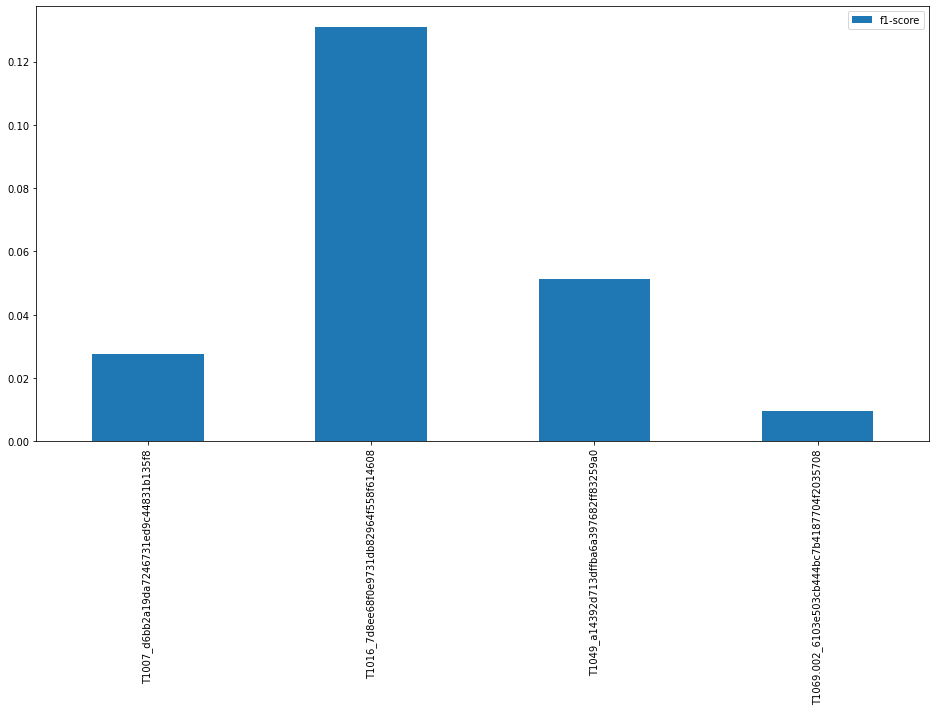

In [36]:
import matplotlib.pyplot as plt

# filtered_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize = (12,8))
filtered_report[['f1-score']].plot(kind='bar', figsize = (16,8))
plt.show()